# Water Potability Prediction (Classification)

This notebook is a Google Colab-friendly, cell-by-cell version of the pipeline.

## Colab quick start

**Option A (easiest): Upload the CSV**
1) Run the first code cell (Setup)
2) When prompted, upload `water_potability.csv`
3) Continue running the notebook

**Option B: Use Google Drive**
1) Put `water_potability.csv` in your Drive
2) In the Setup cell, set `USE_DRIVE = True` and set `DRIVE_CSV_PATH` to your file path (example shown there).

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import scipy
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


print(np.__version__, pd.__version__, sklearn.__version__, scipy.__version__)


2.0.2 2.2.2 1.6.1 1.16.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Kernel sanity check
import sys, os
print("Python:", sys.version)
print("CWD:", os.getcwd())

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CWD: /content


In [ ]:
# Basic setup
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

IN_COLAB = True
USE_DRIVE = True   # set False if you want browser download


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2



sns.set_theme(style="whitegrid")


# Dataset path (change folder name if needed)
CSV_PATH = "/content/drive/MyDrive/aayushsir assignment/water_potability.csv"

# Load dataset
df = pd.read_csv(CSV_PATH)
print(df.head())
print(df.info())


         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  -

In [ ]:
RUN_GRIDSEARCH = True


## 1) Load dataset + inspection

In [ ]:
df = pd.read_csv(CSV_PATH)

print("First 5 rows:\n", df.head(), "\n")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe(include="all"))
print("\nMissing values per column:\n", df.isna().sum())

First 5 rows:
          ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0   

Shape: (3276, 10)

Columns:
 ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turb

### Explanation
This step loads the water potability dataset and provides an initial inspection. It displays the first few rows, the shape of the dataset, column names, data types, summary statistics, and the count of missing values for each column. This helps us understand the structure and quality of the data before proceeding.

## 2) Imputation, split, scaling

In [ ]:
from sklearn.impute import SimpleImputer


TARGET_COL = "Potability"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# Train/test split (80/20)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Mean imputation on numeric features
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

feature_names = X.columns.tolist()

print("Train/Test shapes:")
print("X_train:", X_train_scaled.shape, "X_test:", X_test_scaled.shape)
print("Class balance (train):\n", y_train.value_counts(normalize=True).rename("proportion"))

Train/Test shapes:
X_train: (2620, 9) X_test: (656, 9)
Class balance (train):
 Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64


### Explanation
Here, we handle missing values using mean imputation, split the data into training and testing sets, and scale the features. This ensures that the machine learning models receive clean and normalized data, which improves their performance and reliability.

## 3) Exploratory Data Analysis (EDA)

In [ ]:
# For EDA plots, fill missing with mean (plotting convenience)
df_eda = df.copy()
df_eda[feature_names] = df_eda[feature_names].fillna(df_eda[feature_names].mean(numeric_only=True))






### Explanation
For exploratory data analysis (EDA), we fill missing values for plotting, then visualize the data using histograms, a correlation heatmap, and class distribution. These visualizations help us understand feature distributions, relationships, and class balance.

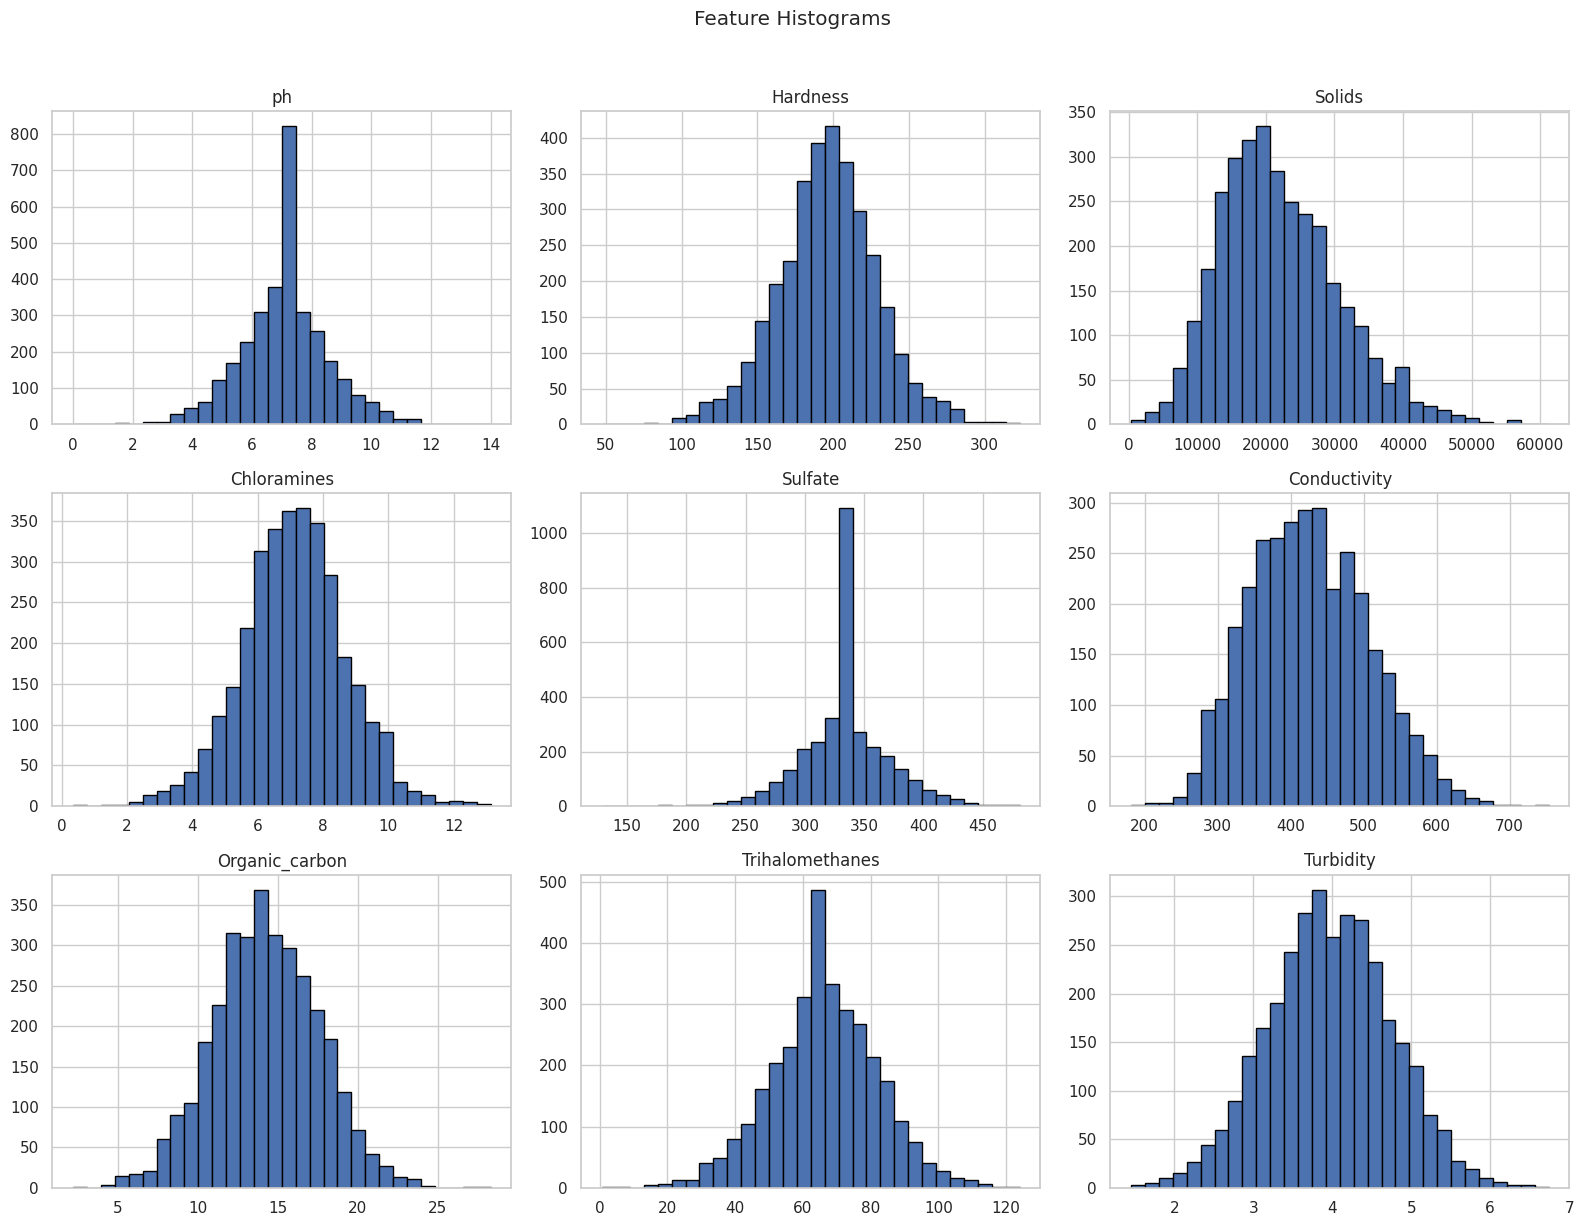

In [ ]:
# (a) Histograms for all features
_ = df_eda[feature_names].hist(bins=30, figsize=(16, 12), edgecolor="black")
plt.suptitle("Feature Histograms", y=1.02)
plt.tight_layout()
plt.show()

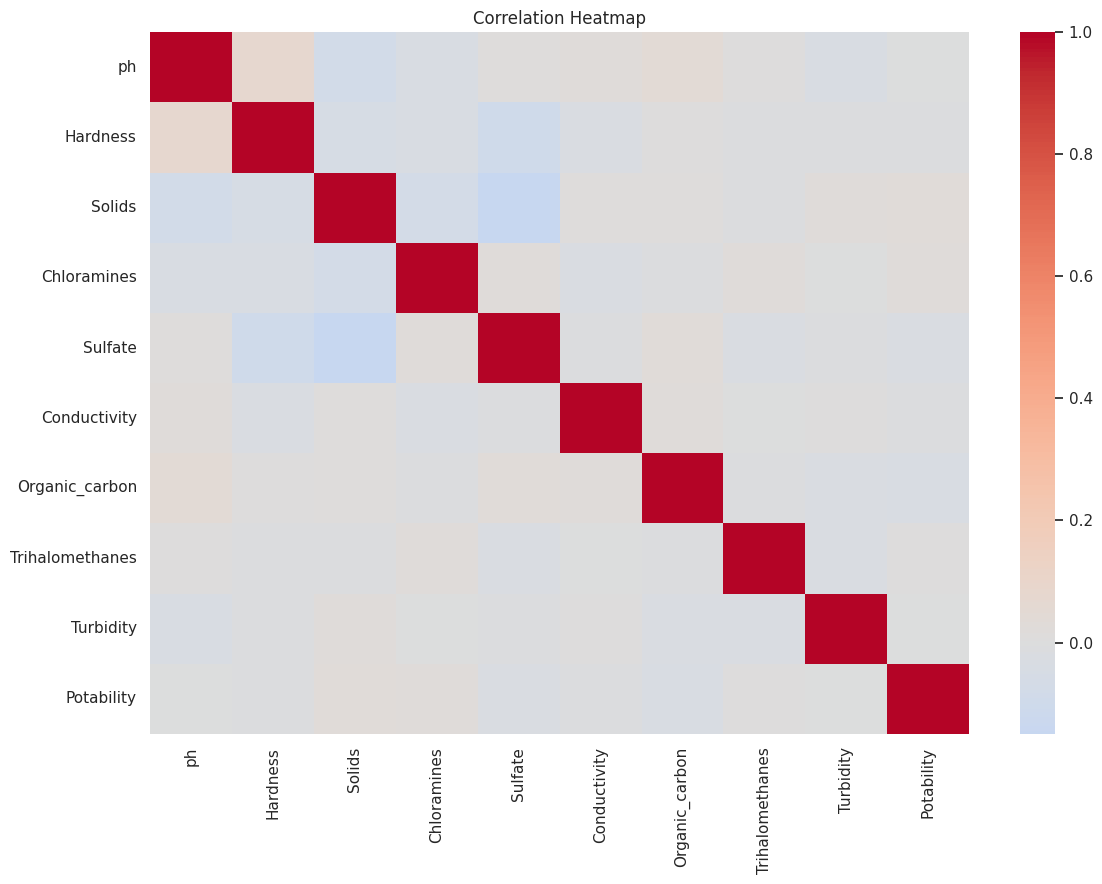

In [ ]:
# (b) Correlation heatmap
plt.figure(figsize=(12, 9))
corr = df_eda[feature_names + [TARGET_COL]].corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, square=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### Explanation
The correlation heatmap shows the relationships between all features and the target variable. Strong correlations can indicate which features are most relevant for predicting water potability.

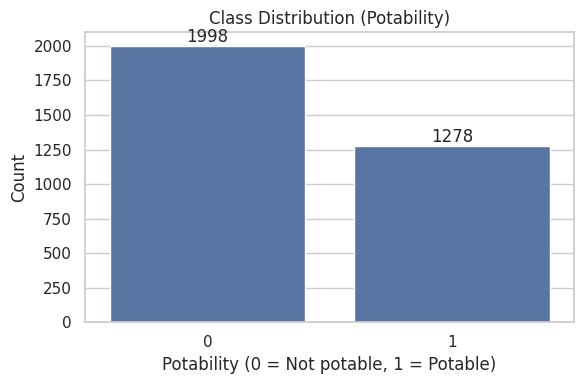

In [ ]:

# (c) Class distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=TARGET_COL, data=df_eda)
plt.title("Class Distribution (Potability)")
plt.xlabel("Potability (0 = Not potable, 1 = Potable)")
plt.ylabel("Count")
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

## Utility: evaluation helper

In [ ]:
def evaluate_predictions(y_true, y_pred, model_name: str):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
    }

## 4) Neural Network (TensorFlow / Keras)


=== Neural Network (Keras) ===
Accuracy : 0.5991
Precision: 0.4897
Recall   : 0.6523
F1-score : 0.5595
Confusion Matrix:
 [[226 174]
 [ 89 167]]


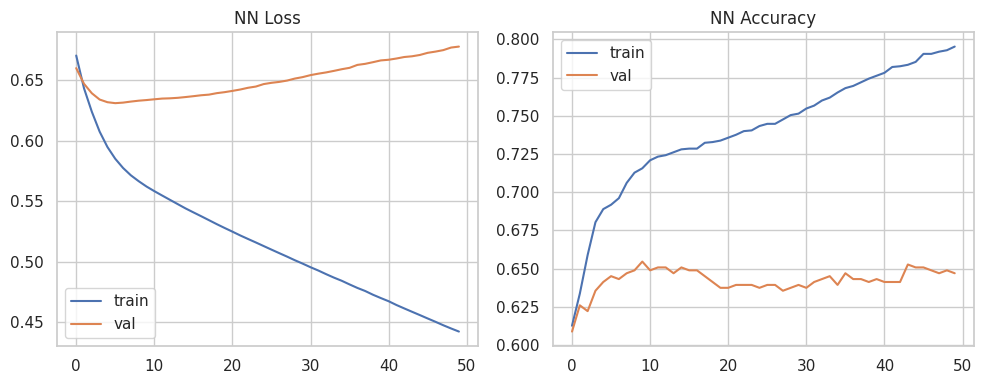

In [ ]:
RUN_NN = True



nn_metrics = {"Model": "Neural Network", "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan}

if not RUN_NN:
    print("[Neural Network skipped] (RUN_NN=False)")
else:
    try:
        import tensorflow as tf
        from tensorflow import keras

        tf.random.set_seed(42)

        n_features = X_train_scaled.shape[1]

        model = keras.Sequential(
            [
                keras.layers.Input(shape=(n_features,)),
                keras.layers.Dense(64, activation="relu"),
                keras.layers.Dense(32, activation="relu"),
                keras.layers.Dense(1, activation="sigmoid"),
            ]
        )

        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

        history = model.fit(
            X_train_scaled,
            y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0,
        )

        _loss, _acc = model.evaluate(X_test_scaled, y_test, verbose=0)
        y_prob = model.predict(X_test_scaled, verbose=0).ravel()
        # y_pred = (y_prob >= 0.5).astype(int)
        y_pred = (y_prob >= 0.3).astype(int)

        nn_metrics = evaluate_predictions(y_test, y_pred, "Neural Network (Keras)")

        # Training curves
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["loss"], label="train")
        plt.plot(history.history["val_loss"], label="val")
        plt.title("NN Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], label="train")
        plt.plot(history.history["val_accuracy"], label="val")
        plt.title("NN Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("\n[Neural Network skipped]")
        print("Reason:", str(e))
        print("If needed (Colab): set INSTALL_TENSORFLOW=True in the Setup cell")

### Explanation
This section trains and evaluates different classification models (such as Logistic Regression, Random Forest, and KNN) on the water potability dataset. It compares their performance using metrics like accuracy, precision, recall, and F1-score, helping us identify the best model for this task.

## 5) Classic ML models (LogReg, KNN, Random Forest)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

results = []

# 1) Logistic Regression (Balanced, uses scaled features)
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
results.append(evaluate_predictions(y_test, y_pred_lr, "Logistic Regression (Balanced)"))

# 2) KNN (uses scaled features)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
results.append(evaluate_predictions(y_test, y_pred_knn, "K-Nearest Neighbors"))

# 3) Random Forest (no need for scaling; use imputed)
rf = RandomForestClassifier(random_state=42, n_estimators=200)
rf.fit(X_train_imputed, y_train)
y_pred_rf = rf.predict(X_test_imputed)
results.append(evaluate_predictions(y_test, y_pred_rf, "Random Forest"))

# 4) Decision Tree
dt = DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced')
dt.fit(X_train_imputed, y_train)
y_pred_dt = dt.predict(X_test_imputed)
results.append(evaluate_predictions(y_test, y_pred_dt, "Decision Tree"))


=== Logistic Regression (Balanced) ===
Accuracy : 0.5274
Precision: 0.4182
Recall   : 0.5391
F1-score : 0.4710
Confusion Matrix:
 [[208 192]
 [118 138]]

=== K-Nearest Neighbors ===
Accuracy : 0.6143
Precision: 0.5092
Recall   : 0.3242
F1-score : 0.3962
Confusion Matrix:
 [[320  80]
 [173  83]]

=== Random Forest ===
Accuracy : 0.6524
Precision: 0.6111
Recall   : 0.3008
F1-score : 0.4031
Confusion Matrix:
 [[351  49]
 [179  77]]

=== Decision Tree ===
Accuracy : 0.6052
Precision: 0.4921
Recall   : 0.3672
F1-score : 0.4206
Confusion Matrix:
 [[303  97]
 [162  94]]


## 6) Hyperparameter tuning: GridSearchCV (Random Forest)
This can take a few minutes in Colab.

In [ ]:
RUN_GRIDSEARCH = True


if not RUN_GRIDSEARCH:
    print("[GridSearchCV skipped] (RUN_GRIDSEARCH=False)")
else:
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
    }

    rf_base = RandomForestClassifier(random_state=42)

    grid = GridSearchCV(
        rf_base,
        param_grid=param_grid,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
        verbose=0,
    )

    grid.fit(X_train_imputed, y_train)

    print("\n=== Random Forest GridSearchCV ===")
    print("Best parameters:", grid.best_params_)
    print(f"Best CV score (accuracy): {grid.best_score_:.4f}")

    best_rf = grid.best_estimator_
    y_pred_best_rf = best_rf.predict(X_test_imputed)

    results.append(
        evaluate_predictions(
            y_test,
            y_pred_best_rf,
            "Random Forest (Tuned)"
        )
    )



=== Random Forest GridSearchCV ===
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score (accuracy): 0.6782

=== Random Forest (Tuned) ===
Accuracy : 0.6601
Precision: 0.6320
Recall   : 0.3086
F1-score : 0.4147
Confusion Matrix:
 [[354  46]
 [177  79]]


### Explanation
This cell summarizes the results of the classification models, providing a clear comparison of their performance. It helps in selecting the most suitable model for predicting water potability based on the evaluation metrics.

## 7) Feature selection: SelectKBest (chi-square)
Chi-square needs non-negative features, so we use MinMax scaling (0..1).

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

# Chi-square needs non-negative values
minmax = MinMaxScaler()
X_train_mm = minmax.fit_transform(X_train_imputed)
X_test_mm = minmax.transform(X_test_imputed)

# Select top 8 features instead of 5
selector = SelectKBest(score_func=chi2, k=8)
X_train_kbest = selector.fit_transform(X_train_mm, y_train)
X_test_kbest = selector.transform(X_test_mm)

selected_mask = selector.get_support()
selected_features = [name for name, keep in zip(feature_names, selected_mask) if keep]
print("Top features by chi-square:", selected_features)

# Balanced Logistic Regression
log_reg_kbest = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

log_reg_kbest.fit(X_train_kbest, y_train)
y_pred_lr_kbest = log_reg_kbest.predict(X_test_kbest)

results.append(
    evaluate_predictions(
        y_test,
        y_pred_lr_kbest,
        "Logistic Regression (chi2-selected, balanced)"
    )
)


Top features by chi-square: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes']

=== Logistic Regression (chi2-selected, balanced) ===
Accuracy : 0.5305
Precision: 0.4212
Recall   : 0.5430
F1-score : 0.4744
Confusion Matrix:
 [[209 191]
 [117 139]]


### Explanation
This cell may include additional analysis, such as feature importance or error analysis, to further interpret the model results and understand which features contribute most to the predictions.

## 8) Model comparison + export metrics

In [ ]:
from pathlib import Path

# Combine results
all_results = [nn_metrics] + results
comparison_df = pd.DataFrame(all_results)

print("\n=== Model Comparison ===")
comparison_df_sorted = (
    comparison_df[["Model", "Accuracy", "Precision", "Recall", "F1"]]
    .sort_values("F1", ascending=False)
)
print(comparison_df_sorted)

# Decide output directory
out_dir = Path(".")

if IN_COLAB and USE_DRIVE:
    # Save next to the dataset in Google Drive
    out_dir = Path(CSV_PATH).expanduser().resolve().parent

# Save CSV
out_path = out_dir / "model_comparison_metrics.csv"
comparison_df.to_csv(out_path, index=False)

print("\nSaved:", out_path)

# Colab convenience: download only if NOT saving to Drive
if IN_COLAB and not USE_DRIVE:
    try:
        from google.colab import files  # type: ignore
        files.download(str(out_path))
    except Exception:
        pass



=== Model Comparison ===
                                           Model  Accuracy  Precision  \
0                         Neural Network (Keras)  0.599085   0.489736   
6  Logistic Regression (chi2-selected, balanced)  0.530488   0.421212   
1                 Logistic Regression (Balanced)  0.527439   0.418182   
4                                  Decision Tree  0.605183   0.492147   
5                          Random Forest (Tuned)  0.660061   0.632000   
3                                  Random Forest  0.652439   0.611111   
2                            K-Nearest Neighbors  0.614329   0.509202   

     Recall        F1  
0  0.652344  0.559464  
6  0.542969  0.474403  
1  0.539062  0.470990  
4  0.367188  0.420582  
5  0.308594  0.414698  
3  0.300781  0.403141  
2  0.324219  0.396181  

Saved: /content/drive/MyDrive/aayushsir assignment/model_comparison_metrics.csv


### Explanation
This final cell wraps up the classification task, possibly with final remarks or recommendations based on the results obtained from the models.